In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/MyDrive/Plantvillage_Dataset"

best_frozen_model.keras  best_model.keras  grayscale
best_model.h5		 color		   segmented


In [5]:
allowed_classes = [
    "Tomato___Target_Spot",
    "Pepper,_bell___Bacterial_spot",
    "Grape___Black_rot",
    "Corn_(maize)___Common_rust_",
    "Cherry_(including_sour)___Powdery_mildew"
] # 5 CLASSES

In [6]:
import os
dataset_path = "/content/drive/MyDrive/Plantvillage_Dataset/color"

selected_classes = [
    cls for cls in os.listdir(dataset_path)
    if cls in allowed_classes
]

print("Selected classes:")
for c in selected_classes:
    print(c)

print("Number of classes:", len(selected_classes))

Selected classes:
Tomato___Target_Spot
Pepper,_bell___Bacterial_spot
Grape___Black_rot
Corn_(maize)___Common_rust_
Cherry_(including_sour)___Powdery_mildew
Number of classes: 5


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

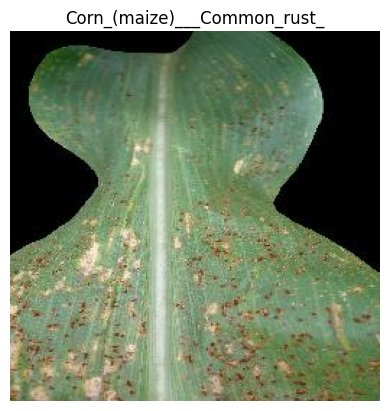

In [7]:
import random
import os
import cv2
import matplotlib.pyplot as plt


class_name = random.choice(selected_classes)
class_path = os.path.join(dataset_path, class_name)

img_name = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(class_name)
plt.axis("off")

In [8]:
import tensorflow as tf
EfficientNetB3 = tf.keras.applications.EfficientNetB3
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

#resize
IMG_SIZE = 256
BATCH_SIZE = 32
SEED = 42

full_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    class_names=selected_classes,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical", # one-hot encoded
    shuffle=False,
    seed=SEED
)

full_ds = full_ds.prefetch(tf.data.AUTOTUNE)

Found 5825 files belonging to 5 classes.


In [9]:
#CHECK FOR NORMALIZATION AND RESIZING
for images, labels in full_ds.take(1):
    print("Min:", tf.reduce_min(images).numpy())
    print("Max:", tf.reduce_max(images).numpy())
    print("Shape:", images.shape)

Min: 0.0
Max: 255.0
Shape: (32, 256, 256, 3)


In [10]:
dataset_size = tf.data.experimental.cardinality(full_ds).numpy()

full_ds = full_ds.shuffle(
    buffer_size=dataset_size,
    seed=SEED,
    reshuffle_each_iteration=False
)

In [11]:
import glob
import numpy as np

image_paths = []
image_labels = []

for idx, class_name in enumerate(selected_classes):
    class_dir = os.path.join(dataset_path, class_name)

    files = []
    for ext in ("*.jpg", "*.JPG", "*.png", "*.jpeg", "*.JPEG"):
        files.extend(glob.glob(os.path.join(class_dir, ext)))

    print(class_name, "→", len(files), "images")

    image_paths.extend(files)
    image_labels.extend([idx] * len(files))

image_paths = np.array(image_paths)
image_labels = np.array(image_labels)


Tomato___Target_Spot → 1404 images
Pepper,_bell___Bacterial_spot → 997 images
Grape___Black_rot → 1180 images
Corn_(maize)___Common_rust_ → 1192 images
Cherry_(including_sour)___Powdery_mildew → 1052 images


In [12]:
from collections import Counter
print("Class counts:", Counter(image_labels))
print("Total images:", len(image_paths))


Class counts: Counter({np.int64(0): 1404, np.int64(3): 1192, np.int64(2): 1180, np.int64(4): 1052, np.int64(1): 997})
Total images: 5825


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths,
    image_labels,
    test_size=0.3,
    stratify=image_labels,
    random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=SEED
)

In [14]:
NUM_CLASSES = len(selected_classes)

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img, tf.one_hot(label, NUM_CLASSES)


train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = (
    train_ds
    .shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [16]:
print("Total batches in full_ds :", tf.data.experimental.cardinality(full_ds).numpy())
print("Train batches           :", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches      :", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches            :", tf.data.experimental.cardinality(test_ds).numpy())

Total batches in full_ds : 183
Train batches           : 128
Validation batches      : 874
Test batches            : 874


In [17]:
#DYNAMIC AUGMENTATION (TRAIN ONLY)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

def augment(x, y):
    x = data_augmentation(x, training=True)
    return x, y

train_ds = train_ds.map(
    augment,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [18]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [19]:
from collections import Counter
import tensorflow as tf

def get_class_counts(ds, name):
    labels = []
    for _, y in ds:
        batch_labels = tf.argmax(y, axis=1).numpy()
        labels.extend(batch_labels.tolist())

    print(f"{name} class counts:", dict(Counter(labels)))

get_class_counts(train_ds, "TRAIN")
get_class_counts(val_ds, "VAL")
get_class_counts(test_ds, "TEST")


TRAIN class counts: {3: 834, 0: 983, 4: 736, 2: 826, 1: 698}
VAL class counts: {4: 158, 3: 179, 2: 177, 1: 150, 0: 210}
TEST class counts: {1: 149, 4: 158, 0: 211, 3: 179, 2: 177}


In [20]:
#CLASS WEIGHTS
import numpy as np

labels = []

for _, y in train_ds:
    batch_labels = tf.argmax(y, axis=1).numpy()
    labels.extend(batch_labels.tolist())

labels = np.array(labels)

In [21]:
from collections import Counter

class_counts = Counter(labels)
clean_class_counts = {int(k): int(v) for k, v in class_counts.items()}
print("Class counts:", clean_class_counts)

Class counts: {0: 983, 2: 826, 4: 736, 1: 698, 3: 834}


In [22]:
class_index_to_name = {i: name for i, name in enumerate(selected_classes)}
print("Class distribution in TRAIN:")
for class_idx, count in clean_class_counts.items():
    class_name = class_index_to_name[class_idx]
    print(f"{class_idx} ({class_name}) → {count} samples")

Class distribution in TRAIN:
0 (Tomato___Target_Spot) → 983 samples
2 (Grape___Black_rot) → 826 samples
4 (Cherry_(including_sour)___Powdery_mildew) → 736 samples
1 (Pepper,_bell___Bacterial_spot) → 698 samples
3 (Corn_(maize)___Common_rust_) → 834 samples


In [23]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

num_classes = len(class_counts)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=labels
)

class_weight_dict = {int(i): float(w) for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: 0.8295015259409969, 1: 1.1681948424068769, 2: 0.9871670702179177, 3: 0.9776978417266187, 4: 1.1078804347826088}


In [24]:
#Build EfficientNetB3
import tensorflow as tf

NUM_CLASSES = len(selected_classes)

base_model = tf.keras.applications.EfficientNetB3(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [25]:
#Freeze
base_model.trainable = False

In [26]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = tf.keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [27]:
import tensorflow as tf

def categorical_focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)

        loss = weight * cross_entropy
        return tf.reduce_sum(loss, axis=1)
    return loss

In [28]:
focal_loss = categorical_focal_loss(alpha=0.25, gamma=2.0)

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss= focal_loss,
    metrics=[
        "accuracy",
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top2_acc")
    ]
)

In [30]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Plantvillage_Dataset/best_frozen_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [31]:
earlystop_cb =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [32]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 8, 8, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,184,436 (42.67 MB)

 Trainable params: 397,829 (1.52 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [ ]:
#Train the Model
EPOCHS = 15

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_cb,earlystop_cb]
)

Epoch 1/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5996 - loss: 0.2197 - top2_acc: 0.7844
Epoch 1: val_loss improved from inf to 0.02685, saving model to /content/drive/MyDrive/Plantvillage_Dataset/best_frozen_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 1189s 9s/step - accuracy: 0.6008 - loss: 0.2189 - top2_acc: 0.7853 - val_accuracy: 0.9336 - val_loss: 0.0268 - val_top2_acc: 0.9840
Epoch 2/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9080 - loss: 0.0352 - top2_acc: 0.9775
Epoch 2: val_loss improved from 0.02685 to 0.00834, saving model to /content/drive/MyDrive/Plantvillage_Dataset/best_frozen_model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 1131s 9s/step - accuracy: 0.9081 - loss: 0.0352 - top2_acc: 0.9776 - val_accuracy: 0.9771 - val_loss: 0.0083 - val_top2_acc: 0.9966
Epoch 3/15
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9416 - loss: 0.0205 - top2_acc: 0.9840
Epoch 3: val_loss improved from 0.00834 to 0.00631, saving model to /content/drive/MyDrive/Plantvi

In [ ]:
import numpy as np

best_epoch = np.argmin(history.history["val_loss"])

train_acc = history.history["accuracy"][best_epoch]
val_acc   = history.history["val_accuracy"][best_epoch]

test_loss, test_acc, test_top2 = model.evaluate(test_ds, verbose=1)

print("\nFINAL MODEL PERFORMANCE")
print(f"Best epoch        : {best_epoch + 1}")
print(f"Train accuracy    : {train_acc:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Test accuracy     : {test_acc:.4f}")
print(f"Test top-2 acc    : {test_top2:.4f}")

In [ ]:
#checking
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/Plantvillage_Dataset/best_model.keras",
    custom_objects={"loss": focal_loss}
)

model.evaluate(test_ds, verbose=1)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def predict_and_show(model, image_path, class_names, img_size=256):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (img_size, img_size))
    img = tf.cast(img, tf.float32)


    img_batch = tf.expand_dims(img, axis=0)


    preds = model.predict(img_batch)
    pred_idx = np.argmax(preds[0])
    confidence = preds[0][pred_idx]


    plt.imshow(img.numpy().astype("uint8"))
    plt.axis("off")
    plt.title(
        f"Prediction: {class_names[pred_idx]}\nConfidence: {confidence*100:.2f}%"
    )
    plt.show()


In [ ]:
 print("All class probabilities:")
    for i, cls in enumerate(class_names):
        print(f"{cls:40s}: {preds[0][i]*100:.2f}%")

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-200]:
    layer.trainable = False

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=focal_loss,
    metrics=[
    "accuracy",
    tf.keras.metrics.TopKCategoricalAccuracy(k=2, name="top2_acc")
]
)

In [ ]:
finetune_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Plantvillage_Dataset/best_finetuned_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [ ]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[finetune_checkpoint_cb, earlystop_cb]
)